In [97]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, StandardScaler

from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [82]:
df = pd.read_csv(r'C:\Users\TSmeitink\Google Drive\DDMA Hackathon\complete_hackathon_dataset.csv').sample(10_000)

## KMeans

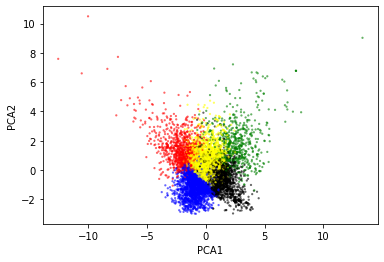

VALUE_COUNTS
 3    3847
1    2590
4    1947
0     998
2     618
Name: clusters, dtype: int64


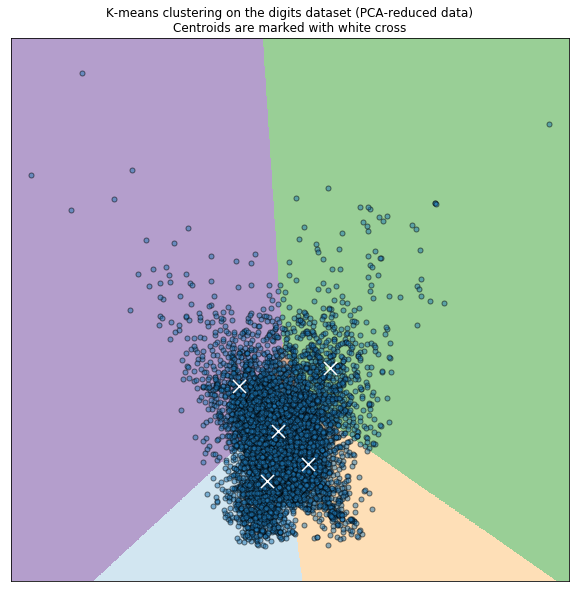

In [95]:
scaler = StandardScaler()

fields = ['indexed_price', 'build_year', 'use_surface', 'parcel_surface', 'number_of_objects', 'score_totaal_2018',
         'huishoudens_met_kinderen', '65_+', 'aantal_inwoners']
X = scaler.fit_transform(df[fields].dropna())

new_df = pd.DataFrame(X, columns=fields)

new_df['clusters'] = KMeans(n_clusters=5).fit(X).labels_

pca = PCA(n_components=2)
pca_comp = np.transpose(pca.fit_transform(new_df[fields]))

colors = {0: 'red', 1:'blue', 2: 'green', 3: 'yellow', 4: 'black'}
plt.scatter(pca_comp[0], pca_comp[1], c=new_df['clusters'].map(colors), edgecolor='none', alpha=0.6, s=5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show();

print("VALUE_COUNTS\n", new_df['clusters'].value_counts())

reduced_data = PCA(n_components=2).fit_transform(new_df[fields])
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.5)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5, marker='o', mec='black', c=None, alpha=0.5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show();

## PCA vs T-SNE

### Create visualization function

In [127]:
def fashion_scatter(x, colors, ndim):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    
    fig = plt.figure(figsize=(10, 10))
    
    if ndim == 2:
        ax = plt.subplot(aspect='equal')
    ax.scatter(x[:,0], x[:,1], s=40, c=palette[colors.astype(np.int)])
    elif ndim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=x[:,0], ys=x[:,1], zs=x[:,2], s=40, c=palette[colors.astype(np.int)])

### Prepare data

In [ ]:
scaler = StandardScaler()

fields = ['indexed_price', 'build_year', 'use_surface', 'parcel_surface', 'number_of_objects', 'score_totaal_2018',
         'huishoudens_met_kinderen', '65_+', 'aantal_inwoners']
X = scaler.fit_transform(df[fields].dropna())

new_df = pd.DataFrame(X, columns=fields)
new_df['clusters'] = KMeans(n_clusters=5).fit(X).labels_

### PCA

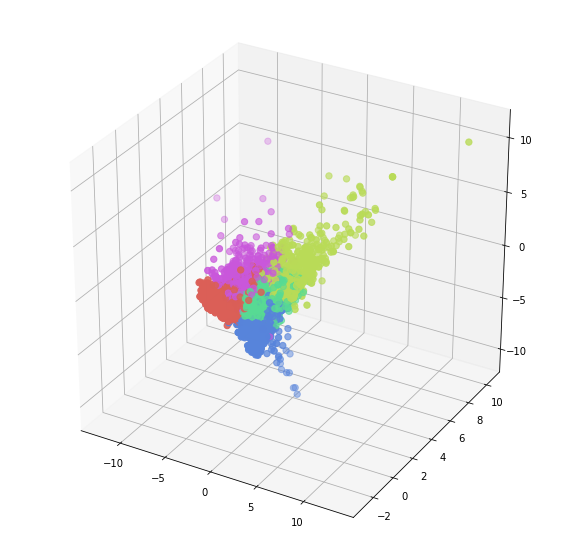

In [136]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(new_df[fields])

pca_df = pd.DataFrame(columns=['pca1','pca2', 'pca3'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]

top_two_comp = pca_df[['pca1','pca2', 'pca3']] # taking first and second principal component

fashion_scatter(top_two_comp.values, new_df['clusters'], 3) # Visualizing the PCA output
plt.show();

### T-SNE

In [ ]:
fashion_tsne = TSNE(n_components=3).fit_transform(new_df[fields])
fashion_scatter(fashion_tsne, new_df['clusters'])
plt.show();